# Описание данных

**Признаки**: 
- *DateCrawled* — дата скачивания анкеты из базы
- *VehicleTyp* — тип автомобильного кузова
- *RegistrationYear* — год регистрации автомобиля
- *Gearbox* — тип коробки передач
- *Power* — мощность (л. с.)
- *Model* — модель автомобиля
- *Kilometer* — пробег (км)
- *RegistrationMonth* — месяц регистрации автомобиля
- *FuelType* — тип топлива
- *Brand* — марка автомобиля
- *NotRepaired* — была машина в ремонте или нет
- *DateCreated* — дата создания анкеты
- *NumberOfPictures* — количество фотографий автомобиля
- *PostalCode* — почтовый индекс владельца анкеты (пользователя)
- *LastSeen* — дата последней активности пользователя

**Целевой признак**:
- *Price* — цена (евро)

## Подготовка данных

Первым делом импортируем необходимые библиотеки.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import uniform
from scipy.stats import loguniform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.dummy import DummyRegressor
import lightgbm
from lightgbm import LGBMRegressor
import time

### Загрузка данных и ознакомление с ними

In [5]:
df = pd.read_csv('autos.csv')

In [6]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DateCrawled,354369,271174,2016-03-24 14:49:47,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,354369.0,NaN,NaN,NaN,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
VehicleType,316879,8,sedan,91457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistrationYear,354369.0,NaN,NaN,NaN,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Gearbox,334536,2,manual,268251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,354369.0,NaN,NaN,NaN,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Model,334664,250,golf,29232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometer,354369.0,NaN,NaN,NaN,128211.172535,37905.34153,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,NaN,NaN,NaN,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
FuelType,321474,7,petrol,216352,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Вывод**:
1. В наборе данных содержатся 354369 строк и 16 столбцов.
2. В 5 столбцах имеются пропущенные значения, которые должны быть обработаны тем или иным образом.
3. Столбец "Почтовый код" неинформативен и должен быть удален. 
4. Столбец "Количество фотографий автомобиля" содержит только нулевые значения, значит тоже должен быть удален.
5. Столбцы, содержащие дату, скорее всего также неинформативны. Однако, если они содержат информацию о разных годах, то вполне могут быть использованы, так как цены на автомобили как правило меняются со временем.
6. В некоторых столбцах замечены аномалии:
    1. В столбце "Год регистрации" минимальное значение - 1000, а максимальное - 9999. Такого не может быть, нужно проверить столбец на наличие аномалий.
    2. В столбце "Мощность" минимальное значение - 0, а максимальное - 20000, чего опять же не может быть в реальности.

### Исследовательский анализ данных

Посмотрим детальнее на данные, чтобы принять правильные решения на стадии предобработки.

#### Даты

Переведем даты в специальный формат.

In [9]:
FORMAT = '%Y-%m-%d %H:%M:%S'

In [10]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format=FORMAT)

In [11]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format=FORMAT)

In [12]:
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format=FORMAT)

Посмотрим, за какой период мы имеем данные.

In [13]:
df[['DateCrawled', 'DateCreated', 'LastSeen']].describe(datetime_is_numeric=True).T

,count,mean,min,25%,50%,75%,max
DateCrawled,354369,2016-03-21 12:58:10.450648320,2016-03-05 14:06:22,2016-03-13 11:52:33,2016-03-21 17:50:55,2016-03-29 14:37:20,2016-04-07 14:36:58
DateCreated,354369,2016-03-20 19:12:07.753274112,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00
LastSeen,354369,2016-03-29 23:51:00.667456768,2016-03-05 14:15:08,2016-03-23 02:50:03,2016-04-03 15:15:51,2016-04-06 10:15:19,2016-04-07 14:58:51


Даты последней активности пользователя и дата скачивания анкеты из базы данных соответствуют марту-началу апреля 2016 года. Некоторые анкеты были созданы до 2016 года. Взглянем на них.

In [14]:
len(df[df.DateCreated.dt.year < 2016])

26

In [15]:
df[df.DateCreated.dt.year < 2016].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
4001,2016-03-23 14:42:46,6000,bus,1995,auto,200,other,150000,0,petrol,chevrolet,no,2015-03-20,0,24558,2016-04-07 03:45:01
9972,2016-03-05 17:53:53,3490,sedan,2006,manual,88,clio,150000,3,petrol,renault,no,2015-11-02,0,40880,2016-03-17 15:46:57
29712,2016-03-28 13:31:25,6950,sedan,2004,auto,150,a3,100000,1,petrol,audi,no,2015-12-06,0,61389,2016-04-06 14:16:09
60168,2016-03-05 20:42:38,5999,sedan,1997,auto,197,c_klasse,150000,9,petrol,mercedes_benz,no,2015-11-17,0,28816,2016-04-06 05:46:03
61207,2016-03-16 11:48:06,8999,NaN,2005,NaN,0,147,125000,0,petrol,alfa_romeo,NaN,2014-03-10,0,79669,2016-04-07 04:46:24


Всего 26 строк, которые выглядят нормальными. 

Так как данные содержат информацию за небольшой промежуток времени, в котором нельзя выделить какие-либо серьезные глобальные экономические изменения, то принимаем решение о том, что дата создания анкеты, загрузки анкеты и последней активности пользователя никак не влияет на цену. Данные столбцы должны быть удалены.

#### Тип кузова

Посмотрим на распределение типов кузова в нашем наборе данных.

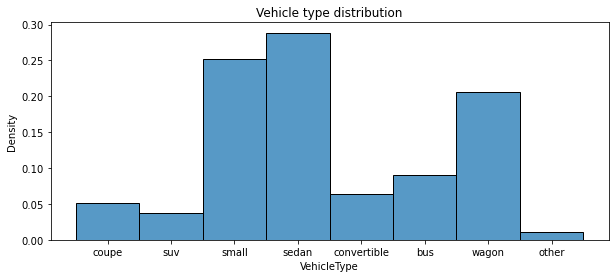

In [16]:
plt.figure(figsize=(10, 4))
sns.histplot(df.VehicleType, stat='density')
plt.title('Vehicle type distribution')
plt.show()

Почти 30% представленных в наборе данных машин - седаны. Около 25% "маленьких" машин. Чуть больше 20% универсалы.

Посмотрим, как тип кузова влияет на цену автомобиля. Так как смотреть на 8 распределений неудобно, сравним лишь средние и медианные значения.

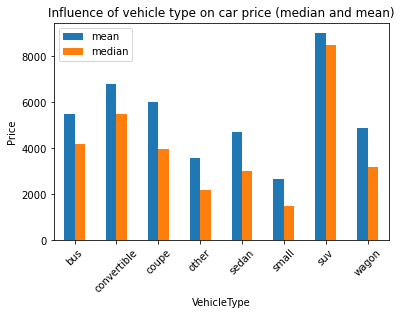

In [17]:
df.groupby('VehicleType')['Price'].agg(['mean', 'median']).plot.bar()
plt.ylabel('Price')
plt.title('Influence of vehicle type on car price (median and mean)')
plt.xticks(rotation=45)
plt.show()

Как мы видим, самая высокая средняя и медианная цена у моделей "suv", что расшифровывается как спортивно-утилитарный. Самые дешевые - автомобили с маленьким кузовом. В принципе результаты логичные.

Также мы можем предположить, что мощность двигателя зависит от типа кузова, так как в маленькую машину скорее всего поставят слабый двигатель, а в большую спортивную машину поставят мощный двигатель. Посмотрим на средние и медианные значения мощности двигателя в зависимости от типа кузова.

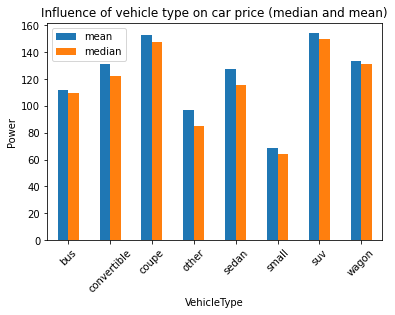

In [18]:
df.groupby('VehicleType')['Power'].agg(['mean', 'median']).plot.bar()
plt.ylabel('Power')
plt.title('Influence of vehicle type on car price (median and mean)')
plt.xticks(rotation=45)
plt.show()

Да, наше предположение оказалось верным.

#### Год и месяц регистрации

Начнем с года регистрации. Как отмечалось выше, в данном столбце есть странные значения, а именно 1000 и 9999. Для начала, взглянем на диаграмма размаха.

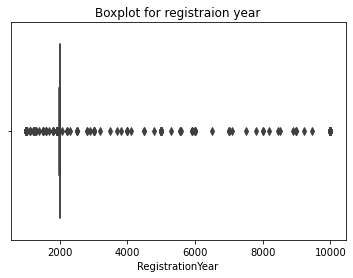

In [19]:
sns.boxplot(data=df, x='RegistrationYear')
plt.title('Boxplot for registraion year')
plt.show()

Распределение имеет тяжелые хвосты. Установим ограничением по осям.

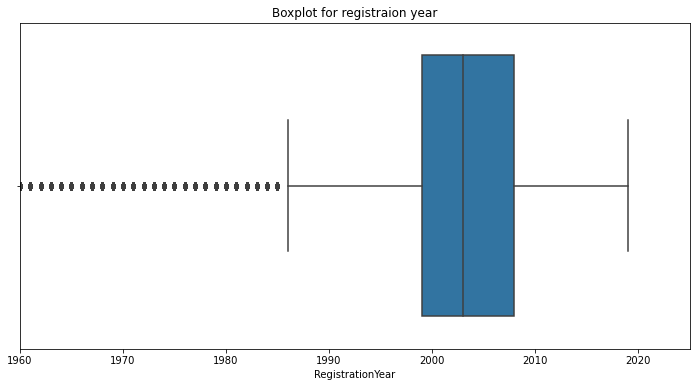

In [20]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='RegistrationYear')
plt.title('Boxplot for registraion year')
plt.xlim(1960, 2025)
plt.show()

Медиана лежит на уровне 2003 года, 25 и 75 перцентили - 1999 и 2008 года. Выбросами можно считать автомоболи, зарегестрированные раньше 1986 года, и позже 2019 года. 

Посмотрим, сколько строк имеют год больше 2019. Очевидно, что это ошибки в записи.

In [21]:
len(df[df.RegistrationYear > 2019]) / len(df)

0.00029630131303810434

Очень маленькое число, поэтому можем их удалить.

Посмотрим, сколько машин, зарегистрированных раньше 1986.

In [22]:
len(df[df.RegistrationYear < 1986]) / len(df)

0.017507174724651423

1.75 %. Что довольно много в контексте нашего датасета. Дата регистрации говорит о старости автомобиля. Так как у нас нет дополнительной информации о том, на какие конкретно автомобили нужна модель, лучше бы сохранить как можно больше данных. Сместим левую границу до 1976 года. Таким образом, оставим в наборе данных автомобили за последние 40 лет.

In [23]:
len(df[df.RegistrationYear < 1976]) / len(df)

0.007156382189186977

Потери при удалении снизятся до величины менее 1 процента.

Не считаются выбросами годы 2017-2019, хотя набор данных составлялся в 2016 году. Посмотрим, сколько строк с такими значениями.

In [24]:
len(df[(df.RegistrationYear > 2016) & (df.RegistrationYear < 2020)]) / len(df)

0.04070615657690148

4%, что довольно много. Мы не можем просто удалить их. Взглянем на несколько из этих строк.

In [25]:
df[(df.RegistrationYear > 2016) & (df.RegistrationYear < 2020)].head(7)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07,0,66115,2016-03-07 18:57:08
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10,0,33397,2016-03-25 10:17:37
65,2016-03-28 17:41:27,10900,NaN,2017,manual,101,astra,50000,3,NaN,opel,no,2016-03-28,0,63607,2016-04-06 23:15:52
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19,0,21698,2016-04-01 08:47:05


Строки выглядят нормальными, однако смущает, что во всех таких строках есть пропуск в столбце "Тип кузова". Посмотрим, сколько строк имеют некорректный год и пропуск.

In [26]:
len(df[(df.RegistrationYear > 2016) & (df.RegistrationYear < 2020) & (df.VehicleType.isna())]) / len(df)

0.04064971823156089

Те же 4%. Скорее всего пропуски неслучайны.

Посмотрим на усеченное распределение.

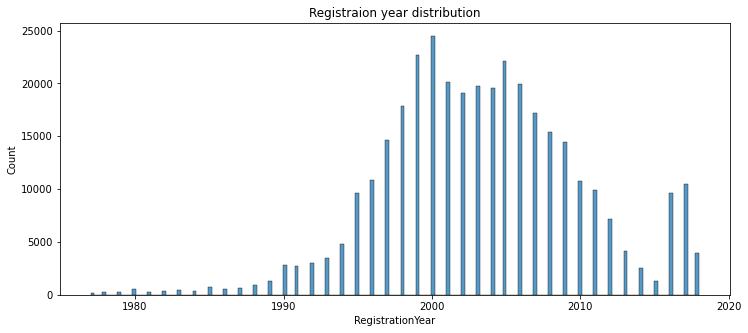

In [27]:
plt.figure(figsize=(12,5))
sns.histplot(df[(df.RegistrationYear > 1976) & (df.RegistrationYear < 2019)]['RegistrationYear'])
plt.title('Registraion year distribution')
plt.show()

Посмотрим, как год регистрации влияет на цену. Рассмотрим среднюю цену в каждом году.

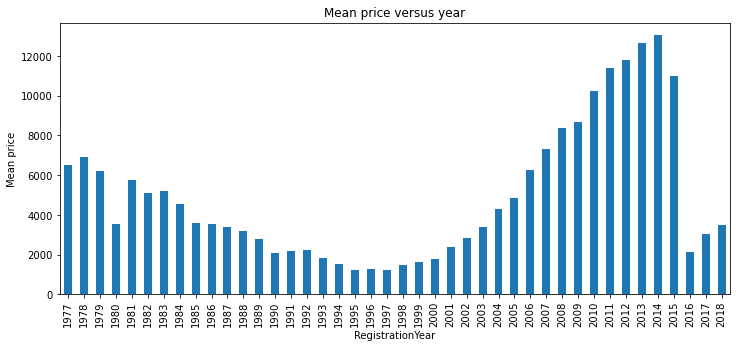

In [28]:
(
    df[(df.RegistrationYear > 1976) & (df.RegistrationYear < 2019)]
    .groupby('RegistrationYear')['Price']
    .mean()
    .plot(kind='bar', figsize=(12,5))
)
plt.title('Mean price versus year')
plt.ylabel('Mean price')
plt.show()

Значения 2016 года и после выбиваются из общего ряда, что еще раз подчеркивает, что данные 2017-2019 года регистрации это ошибка в записи данных.

Не совсем понятно, как корректировать данную ошибку. Самым логичном будет рассмотреть их как пропуски и заполнить одним из популярных методов.

Помимо года регистрации, в наборе данных есть месяц регистрации. Взглянем на его распределение.

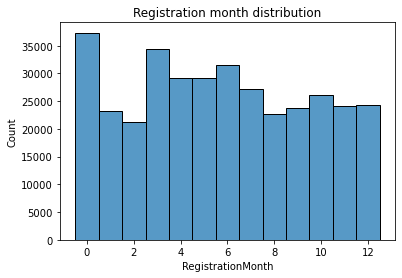

In [29]:
sns.histplot(df.RegistrationMonth, discrete=True)
plt.title('Registration month distribution')
plt.show()

Согласно данной кодировке, в датасете 13 месяцев, чего не может быть. 0 может быть каким-то специальным символом, однако никакой информации у нас нет. Посмотрим на влияние месяца на цену. Рассмотрим среднюю цену.

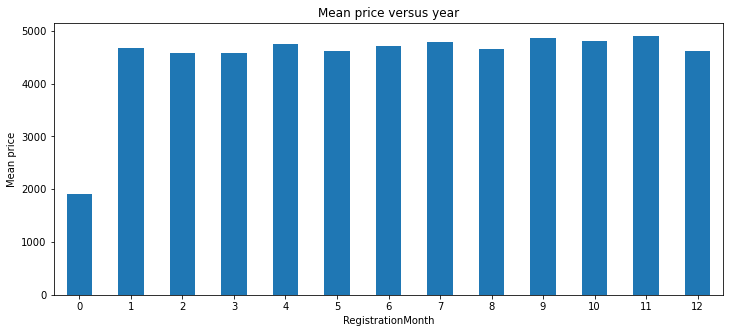

In [30]:
(
    df
    .groupby('RegistrationMonth')['Price']
    .mean()
    .plot(kind='bar', figsize=(12,5))
)
plt.xticks(rotation=0)
plt.title('Mean price versus year')
plt.ylabel('Mean price')
plt.show()

Значение для всех месяцев примерно одинаковое, однако 0 сильно выбивается из общего ряда. Похоже, что под нулем было закодировано что-то необычное. Взглянем на несколько таких строк.

In [31]:
df.query('RegistrationMonth == 0').head(7)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11,0,24148,2016-03-19 08:46:47
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46
36,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,2016-03-11,0,2943,2016-04-07 03:46:09
54,2016-03-17 07:56:40,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no,2016-03-17,0,88433,2016-04-04 04:17:32
69,2016-04-01 11:56:40,1200,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN,2016-04-01,0,47249,2016-04-07 08:46:07


Довольно много пропусков в столбце о ремонте. Посмотрим, сколько их.

In [32]:
len(df[(df.RegistrationMonth == 0) & (df.NotRepaired.isna())])

22096

У 22 тысяч (среди порядка 36 тысяч) машин с нулевым месяцем регистрации пропущено значение в столбце ремонта. Это может быть неслучайно.

Так как значения от 1 до 12 почти не влияют на цену, столбец с месяц регистрации неинформативен для нас. Его можно преобразовать, оставив два значения: нулевой месяц или нет.

Вернемся к рассуждениями о годе регистрации. Наш набор данных составлялся в марте-начале апреля 2016 года. Следовательно автомобили не могут быть зарегестрированы позже апреля 2016 года (даже в апреле регистрация маловероятна). Таким образом, если год 2016, а месяц больше 3, то можно считать это ошибкой записи, заменять данное значение пропуском, а затем обрабатывать. 

#### Тип коробки передач

Взглянем на распределение.

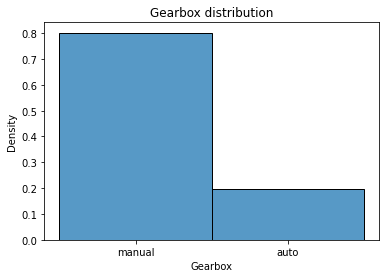

In [33]:
sns.histplot(data=df, x='Gearbox', stat='density')
plt.title('Gearbox distribution')
plt.show()

80% автомобилей имеют механическую коробку передач, 20% - автоматическую.

Посмотрим, как тип коробки влияет на цену автомобиля.

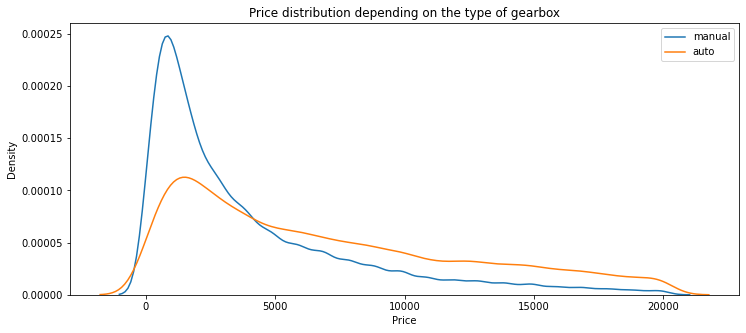

In [34]:
plt.figure(figsize=(12,5))
sns.kdeplot(data=df.query('Gearbox == "manual"'), x='Price', label='manual')
sns.kdeplot(data=df.query('Gearbox == "auto"'), x='Price', label='auto')
plt.legend()
plt.title('Price distribution depending on the type of gearbox')
plt.show()

In [35]:
df.groupby('Gearbox', as_index=False)['Price'].mean()

,Gearbox,Price
0,auto,6842.065007
1,manual,3980.757507


Пик для двух распределений находится примерно на том же уровне, однако для механической коробки передач он намного острее. Среди машин с автоматической трансмиссией больше дорогих машин. Среднее у автомобилей с автоматической коробкой передач значительно выше. Можно заключить, что тип коробки передач влияет на цену.

#### Мощность

Как отмечалось выше, в данном столбце максимальное значение 2000, что похоже на аномалию. Посмотрим на диаграмму размаха.

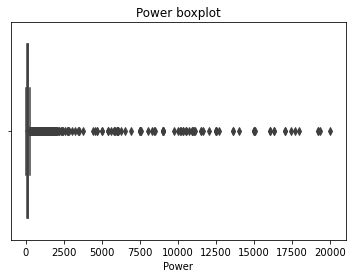

In [36]:
sns.boxplot(data=df, x='Power')
plt.title('Power boxplot')
plt.show()

Распределение сильно скошено вправо. Ограничим ось.

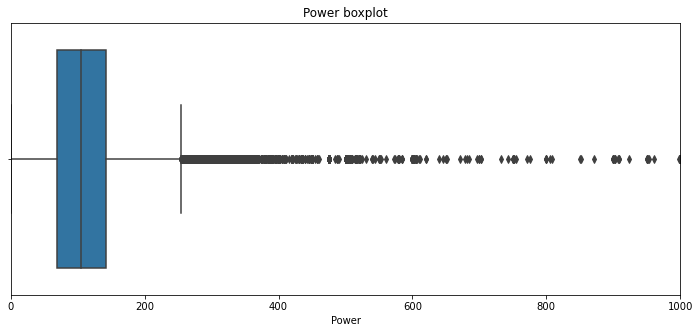

In [37]:
plt.figure(figsize=(12,5))
sns.boxplot(data=df, x='Power')
plt.title('Power boxplot')
plt.xlim(0, 1000)
plt.show()

В соответствии с диаграммой, значения выше 250 лошадиных сил считаются выбросами, однако машины спорт класса могут иметь мощность до 500 лошадиных сил (на самом деле и выше, но для нас это разумная отсечка). Взглянем на несколько строк, где мощность превышает 500 л.с.

In [38]:
df.query('Power > 500').head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22,0,22043,2016-03-22 21:43:26
2102,2016-03-21 11:55:22,0,sedan,1999,NaN,1799,vectra,150000,1,petrol,opel,yes,2016-03-21,0,1723,2016-04-04 04:49:06
3746,2016-03-21 14:48:31,0,NaN,2017,manual,750,NaN,150000,8,petrol,smart,no,2016-03-21,0,49356,2016-03-24 03:44:59
4060,2016-04-03 20:31:00,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,2016-04-03,0,60326,2016-04-07 14:56:46
5328,2016-03-29 19:44:48,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,NaN,2016-03-29,0,33154,2016-04-06 05:44:36


Данные автомобили не имеют данной мощности (что легко проверить, воспользовавшись гуглом). Посмотрим, сколько таких строк в наборе данных.

In [39]:
len(df.query('Power > 600')) / len(df)

0.0010836162305393532

Менее 1 процента. Мы вполне можем удалить их, так как данная мощность неправдоподобна. Ради интереса посмотрим на мощности до 500, но выше 400.

In [40]:
df.query('Power < 500 and Power > 400').head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
2781,2016-03-16 00:37:16,19500,suv,2004,auto,450,cayenne,125000,12,petrol,porsche,no,2016-03-16,0,38448,2016-04-01 22:47:31
3289,2016-03-10 17:46:47,16899,wagon,2003,auto,476,e_klasse,150000,9,petrol,mercedes_benz,no,2016-03-10,0,44319,2016-04-03 18:47:41
4681,2016-03-25 17:57:37,13900,sedan,2006,auto,476,e_klasse,150000,5,petrol,mercedes_benz,no,2016-03-25,0,52078,2016-04-06 23:17:21
5319,2016-03-27 17:57:40,10999,wagon,2006,auto,435,other,150000,12,petrol,audi,yes,2016-03-27,0,52249,2016-04-01 19:17:31
10354,2016-03-27 20:47:03,18900,wagon,2007,auto,420,3er,150000,12,petrol,bmw,no,2016-03-27,0,92358,2016-04-05 19:18:25


Данные мощности имеют дорогие и качественные автомобили. Так что здесь все в порядке. 

Посмотрим на распределение мощностей.

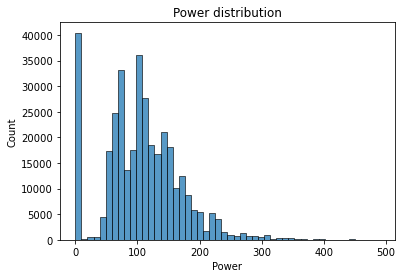

In [41]:
sns.histplot(df.query('Power < 500')['Power'], bins=50)
plt.title('Power distribution')
plt.show()

Распределение имеет мощный острый пик в нуле. Похоже на аномалию. Посчитаем количество таких строк и взглянем на несколько из них.

In [42]:
len(df.query('Power == 0'))

40225

In [43]:
df.query('Power == 0').head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11,0,24148,2016-03-19 08:46:47
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34


Ничего необычного не обнаружено. Скорее всего таким образом закодированы пропуски.

Помимо нулей у нас еще есть крайне малые значения мощности. Посмотрим на распределение, ограничив его величиной 100 л.с.

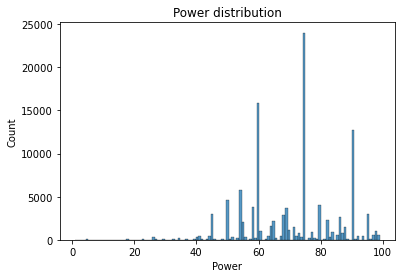

In [44]:
sns.histplot(df.query('Power > 0 and Power < 100')['Power'])
plt.title('Power distribution')
plt.show()

Крайне маловероятно, что автомобиль может иметь мощность ниже 40 л.с. Такие значения проще всего удалить.

#### Модель и марка автомобиля

Взглянем, сколько всего брэндов представлено в наборе данных.

In [45]:
df.Brand.nunique()

40

Взглянем на 10 самых часто встречающихся марок.

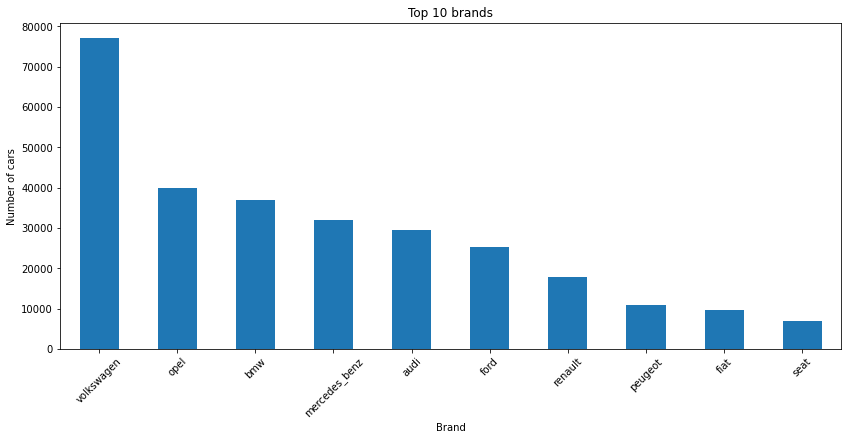

In [46]:
df.groupby('Brand')['Brand'].count().sort_values(ascending=False)[:10].plot(kind='bar', figsize=(14,6))
plt.xticks(rotation=45)
plt.title('Top 10 brands')
plt.ylabel('Number of cars')
plt.show()

Абсолютным лидером является Фольксваген.

А теперь взглянем на 10 марок с самой высокой средней ценой.

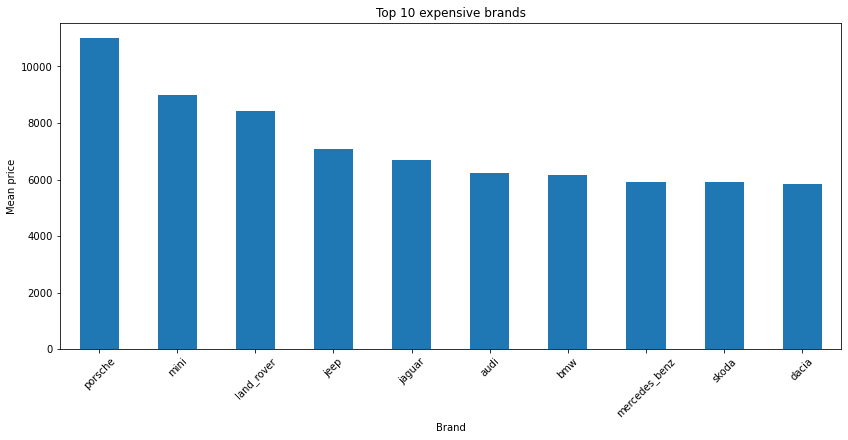

In [47]:
df.groupby('Brand')['Price'].mean().sort_values(ascending=False)[:10].plot(kind='bar', figsize=(14,6))
plt.xticks(rotation=45)
plt.title('Top 10 expensive brands')
plt.ylabel('Mean price')
plt.show()

Здесь другие лидеры. БМВ, Ауди и Мерседес-бенц вошли в оба топа.

Теперь взглянем на количество моделей.

In [48]:
df.Model.nunique()

250

Их довольно много, взглянем на 20 наиболее частых.

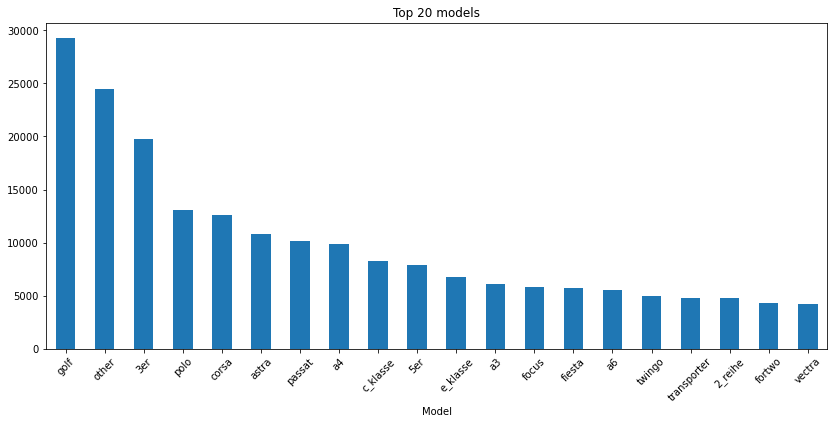

In [49]:
df.groupby('Model')['Model'].count().sort_values(ascending=False)[:20].plot(kind='bar', figsize=(14,6))
plt.xticks(rotation=45)
plt.title('Top 20 models')
plt.show()

И на 20 наиболее дорогих (по средней цене).

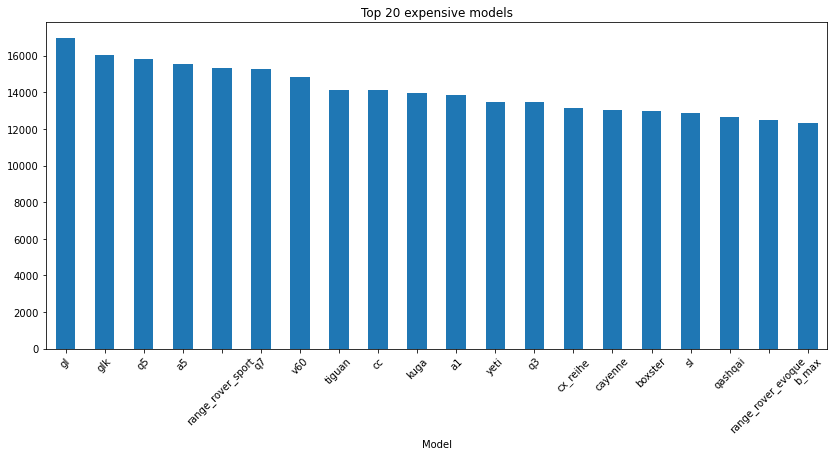

In [50]:
df.groupby('Model')['Price'].mean().sort_values(ascending=False)[:20].plot(kind='bar', figsize=(14,6))
plt.xticks(rotation=45)
plt.title('Top 20 expensive models')
plt.show()

Лидерами являются модели Мерседес-бенц и Ауди.

#### Пробег

Посмотрим на пробег автомобилей.

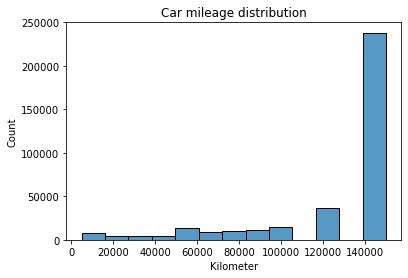

In [51]:
sns.histplot(df.Kilometer, bins=13)
plt.title('Car mileage distribution')
plt.show()

Мощный острый пик на уровне 150000. Посмотрим, сколько именно машин с таким пробегом.

In [52]:
len(df.query('Kilometer == 150000')) / len(df)

0.6722060902618457

Величина хоть и реальная, но довольно странная. Возможно это максимально возможная величина счетчика, или счетчик был скручен или что-то в этом духе. Имеет смысл сравнить машины с пробегом 150000 км и с пробегом ниже. Сравним цены у двух групп.

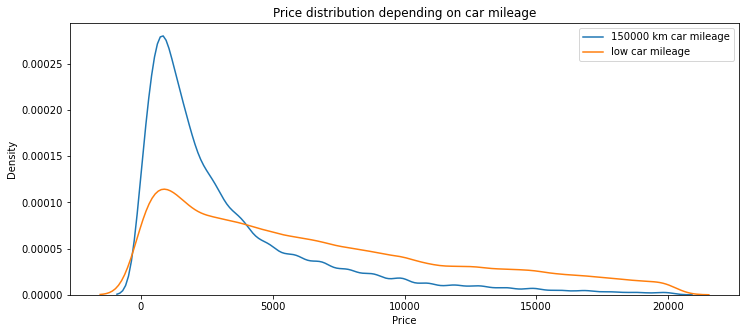

In [53]:
plt.figure(figsize=(12,5))
sns.kdeplot(df.query('Kilometer == 150000')['Price'], label='150000 km car mileage')
sns.kdeplot(df.query('Kilometer != 150000')['Price'], label='low car mileage')
plt.legend()
plt.title('Price distribution depending on car mileage')
plt.show()

In [54]:
print(df.query('Kilometer == 150000')['Price'].mean())
print(df.query('Kilometer != 150000')['Price'].mean())

3363.439009441289
6576.487620523416


Среднее и распределения отличаются. Делаем вывод, что машины с максимальным пробегом дешевле.

Посмотрим, сколько всего значений пробега.

In [55]:
df.Kilometer.nunique()

13

Похоже, что автомобили разбиты на какие-то группы. Посмотрим на значение средней цены в группе.

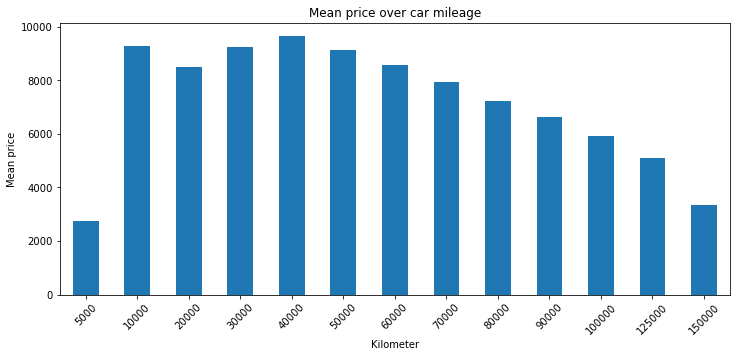

In [56]:
df.groupby('Kilometer')['Price'].mean().plot(kind='bar', figsize=(12,5))
plt.title('Mean price over car mileage')
plt.ylabel('Mean price')
plt.xticks(rotation=45)
plt.show()

Машины с высоким пробегом стоят дешевле.

#### Тип топлива

Посмотрим, какие типы топлива представлены в наборе данных.

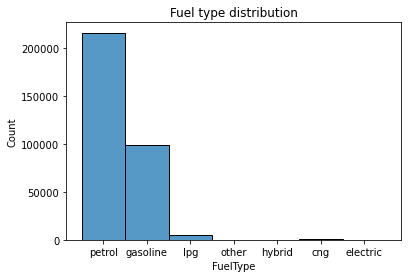

In [57]:
sns.histplot(df.FuelType)
plt.title('Fuel type distribution')
plt.show()

In [58]:
df.FuelType.value_counts().to_frame()

,FuelType
petrol,216352
gasoline,98720
lpg,5310
cng,565
hybrid,233
other,204
electric,90


Большинство машин используют *petrol* и *gasoline*. Интересно, но это два одинаковых топлива, которые имеют лишь разные названия в Америке и Европе. Взглянем, отличается ли цена.

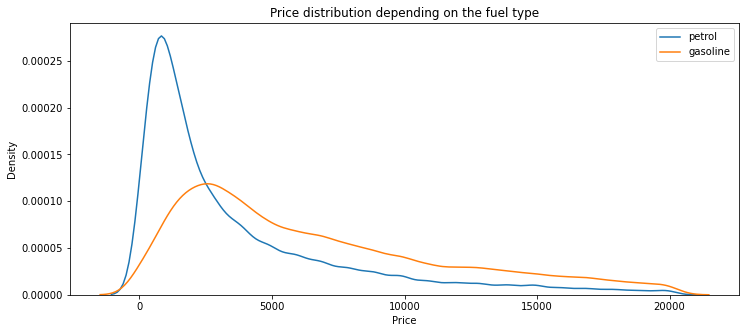

In [59]:
plt.figure(figsize=(12,5))
sns.kdeplot(df.query('FuelType == "petrol"')['Price'], label='petrol')
sns.kdeplot(df.query('FuelType == "gasoline"')['Price'], label='gasoline')
plt.legend()
plt.title('Price distribution depending on the fuel type')
plt.show()

Удивительно, но разница выглядит существенной. Автомобили, использующие *gasoline* дороже. И мы должны учитывать эту разницу, несмотря на то, что на русский язык оба топлива переводятся как бензин.

#### Была ли машина в ремонте

Посмотрим, сколько машин было в ремонте.

In [60]:
df.NotRepaired.value_counts().to_frame()

,NotRepaired
no,247161
yes,36054


Большинство машин не было в ремонте. Можно предположить, что старые машины чаще бывают в ремонте, проверим это.

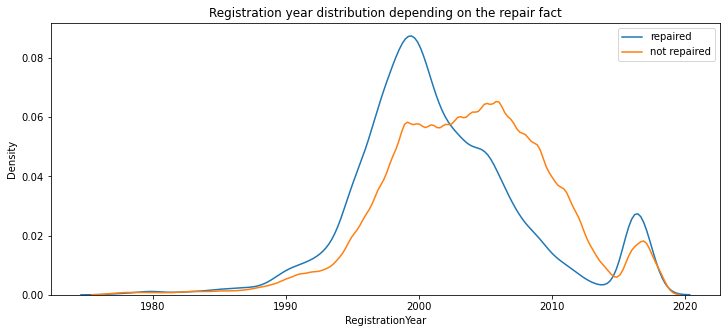

In [61]:
plt.figure(figsize=(12,5))
sns.kdeplot(df.query('NotRepaired == "yes" \
                     and RegistrationYear < 2019 \
                     and RegistrationYear > 1976')['RegistrationYear'], label='repaired')
sns.kdeplot(df.query('NotRepaired == "no" \
                     and RegistrationYear < 2019 \
                     and RegistrationYear > 1976')['RegistrationYear'], label='not repaired')
plt.legend()
plt.title('Registration year distribution depending on the repair fact')
plt.show()

Наше предположение подтвердилось. Старые машины чаще бывают в ремонте.

Посмотрим, влияет ли ремонт на цену.

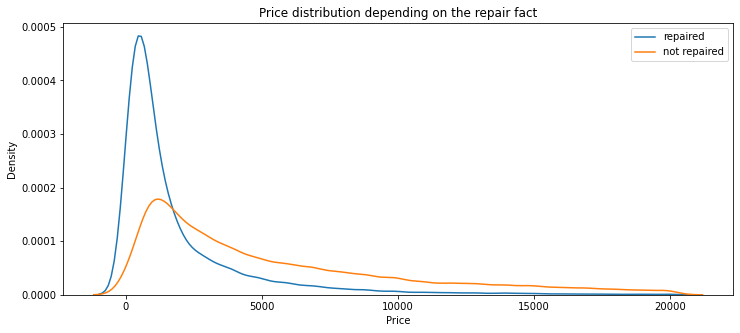

In [62]:
plt.figure(figsize=(12,5))
sns.kdeplot(df.query('NotRepaired == "yes"')['Price'], label='repaired')
sns.kdeplot(df.query('NotRepaired == "no"')['Price'], label='not repaired')
plt.legend()
plt.title('Price distribution depending on the repair fact')
plt.show()

Машины, побывавшие в ремонте, как правило дешевле.

#### Цена

Посмотрим на распределение целевого признака.

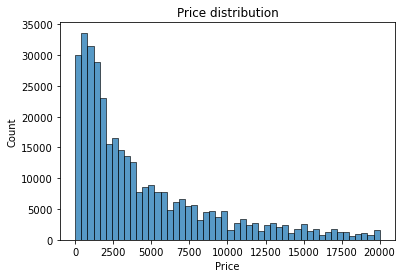

In [63]:
sns.histplot(df.Price, bins=50)
plt.title('Price distribution')
plt.show()

У распределения пик на уровне низких значений и тяжелый хвост. Максимальная цена автомобиля - 20000 евро. Имеется много автомобилей с ценой ниже 1000 евро, что кажется странным. Взглянем на эти значения.

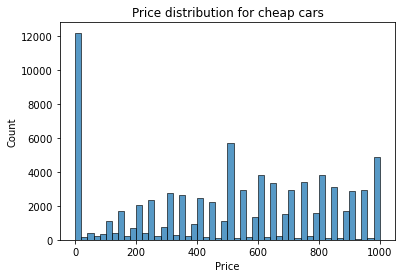

In [64]:
sns.histplot(df.query('Price < 1000').Price, bins=50)
plt.title('Price distribution for cheap cars')
plt.show()

Порядка 12000 автомобилей имеют околонулевую стоимость, чего не может быть в реальности. Данные строки нужно удалить, так как по ним бессмысленно обучать модель. Нужно выбрать какую-то границу, ниже которой все цены будут являться выбросами. Установим ее на 200 евро. Посмотрим, сколько строк мы лишимся в таком случае.

In [65]:
len(df.query('Price < 200')) / len(df)

0.049276319316870265

Почти 5% строк, однако у нас нет другого выбора, кроме как удалить их, иначе модель будет выдавать странные значения.

#### Вывод

1. В данных преимущественно содержится информация об анкетах за 2016 год. Дата создания анкеты, загрузки анкеты и последней активности пользователя никак не влияет на цену. Данные столбцы должны быть удалены.
2. В наборе данных представлены автомобили с разным типом кузова. Лидером являются седаны. Тип кузова влияет на цену: самая высокая средняя и медианная цена у моделей "suv" (спортивно-утилитарный). Самые дешевые - автомобили с маленьким кузовом. Также тип кузова связан с мощность двигателя.
3. В наборе данных присутствуют аномалии в столбце "Год регистрации". Было решено считать выбросами года раньше 1976 и позже 2016. Строки, зарегестрированные с апреля 2016 по 2019 год, нужно обработать, заменив год на пропуск и заполнив тем или иным образом. Год регистрации влияет на среднню цену автомобилей. С 1997 до 2015 года она росла. Месяц регистрации никак не влияет на цену, однако есть значение "0", которое выбивается из общего ряда, и не совсем понятно, что оно означает. Логично будет модифицировать столбец, чтобы он показывал не конкретный месяц регистрации, а является ли месяц нулевым или нет.
4. Автомобили с автоматической коробкой передач обычно дороже.
5. Столбец "Мощность" имеет аномалии. Порядка 40 тысяч строк имеют нулевую мощность, чего не может быть. Данные нули было решено интерпретировать как пропуски. Было рещено рассматривать автомобили имеющие мощность от 40 до 500 лошадиных сил, остальные же значения удалить. Не рассматривая выбросы, распределение мощности похоже на нормальное, но имеет скос вправо.
6. В наборе данных представлено 40 марок автомобилей и 250 моделей.
7. Максимальный пробег у машин 150000 км. 2/3 автомобилей имеют такой пробег. Машины с большим пробегом дешевле.
8. В наборе данных присутствуют автомобили с 7 видами топлива. Наиболее представленными являются *gasoline* и *petrol*, что в принципе является одним и тем же (бензином), однако распределение цены для этих типов топлива разное.
9. Большинство машин не было в ремонте. В ремонте как правило были более старые и дешевые автомобили.
10. Целевой признак в наборе данных - цена автомобиля. Оно имеет распределение Пуассона. Имеются автомобили с ценой 0 евро, чего не может быть. Было решено считать автомобили дешевле 200 евро - выбросами. Их нужно удалить.

### Обработка аномалий и изменение/удаление столбцов

В данном пункте мы обработаем аномалии, обнаруженные на предыдущем шаге.

Сохраним изначальный размер датасета.

In [66]:
initial_shape = df.shape

In [67]:
initial_shape

(354369, 16)

#### Неинформативные столбцы

Удаляем неинформативные столбцы.

In [68]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

#### Год и месяц регистрации

Удаляем строки, содержащие автомобили с годами регистрации ранее 1976 и позднее 2019 года.

In [69]:
df = df.drop(df[(df.RegistrationYear < 1976) | (df.RegistrationYear > 2019)].index)

Проверяем, сколько строк было удалено.

In [70]:
first_shape = df.shape
initial_shape[0] - first_shape[0]

2641

Как было сказано ранее, автомобили, зарегестрированные после марта 2016 года и по 2019 год, являются ошибкой записи. С целью сохранения наибольшего количества данных, было решено интерпретировать их как пропуски, и в последствии заполнить.

In [71]:
df.RegistrationYear.isna().sum()

0

In [72]:
df['RegistrationYear'] = df['RegistrationYear'].apply(lambda x: np.nan if x > 2016 else x)

In [73]:
df.RegistrationYear.isna().sum()

14425

In [74]:
df['RegistrationYear'] = df.apply(lambda row: np.nan 
                                  if row['RegistrationYear'] == 2016 and row['RegistrationMonth'] > 3 
                                  else row['RegistrationYear'], axis=1)

In [75]:
df.RegistrationYear.isna().sum()

19787

Почти 20000 автомобилей имели дату регистрации позднее, чем дата сбора данных, чего быть не может. Это было расценено как ошибка записи, и для сохранения как можно больше объема данных эти ошибки были интерпретированы как пропуски.

Преобразуем столбец месяца регистрации. Так как значения 1-12 почти не отличаются, а значение 0 имеет сильное отличие, изменим смысл всего столбца. Теперь он будет содержать только 0 и 1, говоря о том, является ли месяц нулевым или нет.

In [76]:
df['RegistrationMonth'] = df['RegistrationMonth'].apply(lambda x: 1 if x > 0 else 0)

In [77]:
df['RegistrationMonth'].value_counts().to_frame()

,RegistrationMonth
1,315092
0,36636


#### Мощность двигателя

В данном столбце много нулевых значений, которые было решено интерпретировать как пропуски. Заменим нули на пропуски, чтобы потом их заполнить.

In [78]:
df.Power.isna().sum()

0

In [79]:
df['Power'] = df['Power'].apply(lambda x: np.nan if x == 0 else x)

In [80]:
df.Power.isna().sum()

39194

Помимо этого, удаляем подозрительно низкие и высокие значения. 

In [81]:
df = df.drop(df[(df['Power'] < 40) | (df['Power'] > 500)].index)

Посмотрим, сколько строк было удалено.

In [82]:
second_shape = df.shape
first_shape[0] - second_shape[0]

1543

#### Цена автомобиля

Целью данной работы является построение модели, способной предсказывать цену автомобиля по его характеристикам. В наборе данных есть строки с нулевым или подозрительно низким значением цены (чего не может быть в действительности). Данные строки бесполезны (или даже вредны для модели), и поэтому мы их удаляем.

In [83]:
df = df.drop(df[df['Price'] < 200].index)

Посмотрим, сколько строк было удалено.

In [84]:
second_shape[0] - df.shape[0] 

16920

Сколько строк было удалено всего.

In [85]:
initial_shape[0] - df.shape[0]

21104

Посмотрим, какой суммарно процент строк был удален, чтобы избавиться от аномалий. 

In [86]:
(initial_shape[0] - df.shape[0]) / initial_shape[0] 

0.059553742003391946

Порядка 6% строк было удалено.

Взглянем на первые строки обновленного набора данных.

In [87]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993.0,manual,NaN,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011.0,manual,190.0,NaN,125000,1,gasoline,audi,yes
2,9800,suv,2004.0,auto,163.0,grand,125000,1,gasoline,jeep,NaN
3,1500,small,2001.0,manual,75.0,golf,150000,1,petrol,volkswagen,no
4,3600,small,2008.0,manual,69.0,fabia,90000,1,gasoline,skoda,no


### Подготовка данных для модели градиентного бустинга

Как известно, библиотеки LightGBM и CatBoost могут работать с категориальными переменными, а также они сами могут обрабатывать пропуски. В таком случае, для модели градиентного бустинга дальнейшая предобработка не требуется. Нужно лишь выделить обучающую и тестовую выборки и изменить тип данных категориальных столбцов.

Так как мы будем проводить предобработку для изучения других моделей, имеет смысл посмотреть, в каком случае градиентный бустинг выдаст наилучший результат - с предварительной обработкой или без обработки.

Разобьем данные на обучающую и тестовую выборки.

In [88]:
X_train_boost, X_test_boost, y_train_boost, y_test_boost = train_test_split(df.drop('Price', axis=1),
                                                                            df.Price,
                                                                            test_size=0.2,
                                                                            random_state=42
)

Выполним проверку.

In [89]:
print(X_train_boost.shape)
print(X_test_boost.shape)
print(y_train_boost.shape)
print(y_test_boost.shape)

(266612, 10)
(66653, 10)
(266612,)
(66653,)


Важно, чтобы распределение целевого признака в обеих выборках было похожим, проверим это.

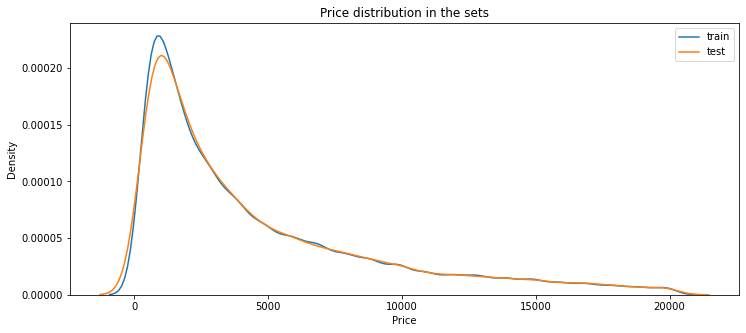

In [90]:
plt.figure(figsize=(12,5))
sns.kdeplot(y_train_boost, label='train')
sns.kdeplot(y_test_boost, label='test')
plt.title('Price distribution in the sets')
plt.legend()
plt.show()

Разбиение считаем удовлетворительным. Запоминаем зерно рандома, будем его использовать при разбиении обработанных вручную данных.

Выделим категории.

In [91]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

Изменим тип данных.

In [92]:
for col in cat_features:
    X_train_boost[col] = X_train_boost[col].astype('category')
    X_test_boost[col] = X_test_boost[col].astype('category')

In [93]:
X_train_boost.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
196899,NaN,NaN,manual,109.0,focus,150000,1,gasoline,ford,NaN
293602,sedan,2001.0,manual,64.0,polo,150000,1,petrol,volkswagen,NaN
344160,convertible,2005.0,manual,116.0,cooper,100000,1,petrol,mini,no
296464,small,2004.0,manual,75.0,polo,150000,1,gasoline,volkswagen,no
274439,sedan,1998.0,manual,118.0,3er,150000,1,lpg,bmw,yes


In [94]:
X_train_boost.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266612 entries, 196899 to 129690
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   VehicleType        241807 non-null  category
 1   RegistrationYear   251833 non-null  float64 
 2   Gearbox            254620 non-null  category
 3   Power              240296 non-null  float64 
 4   Model              254101 non-null  category
 5   Kilometer          266612 non-null  int64   
 6   RegistrationMonth  266612 non-null  int64   
 7   FuelType           245470 non-null  category
 8   Brand              266612 non-null  category
 9   NotRepaired        217410 non-null  category
dtypes: category(6), float64(2), int64(2)
memory usage: 12.0 MB


### Кодирование категориальных признаков

Создадим копию набора данных, в которой будем проводить изменения.

In [95]:
df_prep = df.copy()

Обычно для кодирования используется техника One Hot Encoding. В нашем случае она приведет к серьезному расширению признакового пространства (столбец "Модель" содержит 250 категорий). Беря во внимание большой размер нашего набора данных, увеличение признакового пространства в десятки раз существенно увеличит время обучения. Поэтому будем использовать порядковое кодирование.

In [96]:
encoder = OrdinalEncoder()
df_prep[cat_features] = encoder.fit_transform(df_prep[cat_features])

In [97]:
df_prep.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993.0,1.0,NaN,116.0,150000,0,6.0,38.0,NaN
1,18300,2.0,2011.0,1.0,190.0,NaN,125000,1,2.0,1.0,1.0
2,9800,6.0,2004.0,0.0,163.0,117.0,125000,1,2.0,14.0,NaN
3,1500,5.0,2001.0,1.0,75.0,116.0,150000,1,6.0,38.0,0.0
4,3600,5.0,2008.0,1.0,69.0,101.0,90000,1,2.0,31.0,0.0


Кодирование проведено успешно.

### Заполнение пропусков

Посмотрим, сколько пропусков имеем.

In [98]:
df_prep.isna().sum().to_frame()

,0
Price,0
VehicleType,30915
RegistrationYear,18347
Gearbox,14984
Power,32912
Model,15703
Kilometer,0
RegistrationMonth,0
FuelType,26536
Brand,0


Правильно будет разбить данные на обучающую и тестовую выборки, и заполнить тестовую выборку на основе обучающей.

In [99]:
X_train, X_test, y_train, y_test = train_test_split(df_prep.drop('Price', axis=1),
                                                    df_prep.Price,
                                                    test_size=0.2,
                                                    random_state=42
)

In [100]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(266612, 10)
(66653, 10)
(266612,)
(66653,)


Заполним пропуски с помощью итеративного импьютера.

In [101]:
imputer = IterativeImputer(random_state=42)
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [102]:
X_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,4.482412,2004.381674,1.0,109.0,103.0,150000.0,1.0,2.0,10.0,0.120520
1,4.000000,2001.000000,1.0,64.0,173.0,150000.0,1.0,6.0,38.0,0.139153
2,1.000000,2005.000000,1.0,116.0,80.0,100000.0,1.0,6.0,21.0,0.000000
3,5.000000,2004.000000,1.0,75.0,173.0,150000.0,1.0,2.0,38.0,0.000000
4,4.000000,1998.000000,1.0,118.0,11.0,150000.0,1.0,4.0,2.0,1.000000


In [103]:
X_test.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,7.000000,2009.0,1.000000,110.000000,170.0,150000.0,1.0,2.000000,38.0,0.000000
1,4.041713,1995.0,0.829607,104.600209,102.0,80000.0,0.0,6.631182,10.0,0.326125
2,4.000000,2008.0,1.000000,80.000000,173.0,60000.0,1.0,6.000000,38.0,0.000000
3,3.000000,1999.0,1.000000,68.000000,166.0,150000.0,1.0,2.000000,30.0,1.000000
4,4.000000,2010.0,0.000000,245.000000,19.0,60000.0,1.0,2.000000,2.0,0.000000


Округлим полученные значения.

In [104]:
X_train = X_train.round().astype(int)
X_test = X_test.round().astype(int)

In [105]:
X_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,4,2004,1,109,103,150000,1,2,10,0
1,4,2001,1,64,173,150000,1,6,38,0
2,1,2005,1,116,80,100000,1,6,21,0
3,5,2004,1,75,173,150000,1,2,38,0
4,4,1998,1,118,11,150000,1,4,2,1


In [106]:
X_train.isna().sum()

VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
dtype: int64

In [107]:
X_test.isna().sum()

VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
dtype: int64

Пропуски были успешно заполнены.

### Стандартизация

Стандартизируем численные признаки.

In [108]:
scaler = StandardScaler(copy=False)
scaler.fit(X_train[['RegistrationYear', 'Power', 'Kilometer']])
X_train[['RegistrationYear', 'Power', 'Kilometer']] = scaler.transform(X_train[['RegistrationYear', 'Power', 'Kilometer']])
X_test[['RegistrationYear', 'Power', 'Kilometer']] = scaler.transform(X_test[['RegistrationYear', 'Power', 'Kilometer']])

Посмотрим на первые строки обучающей и тестовой выборки.

In [109]:
X_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,4,0.224524,1,-0.224640,103,0.573523,1,2,10,0
1,4,-0.293733,1,-1.107054,173,0.573523,1,6,38,0
2,1,0.397277,1,-0.087375,80,-0.791809,1,6,21,0
3,5,0.224524,1,-0.891353,173,0.573523,1,2,38,0
4,4,-0.811991,1,-0.048157,11,0.573523,1,4,2,1


In [110]:
X_test.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,7,1.088287,1,-0.205030,170,0.573523,1,2,38,0
1,4,-1.330249,1,-0.303076,102,-1.337941,0,7,10,0
2,4,0.915534,1,-0.793307,173,-1.884074,1,6,38,0
3,3,-0.639239,1,-1.028617,166,0.573523,1,2,30,1
4,4,1.261039,0,2.442214,19,-1.884074,1,2,2,0


Стандартизация проведена успешно.

### Вывод

1. Данные были загружены. Изначально набор данных содержал 354369 строк и 16 столбцов.
2. Был проведен исследовательский анализ данных, в результате которого были установлены факторы, влияющие на цену автомобиля, а также найдены аномалии в данных.
3. Неинформативные столбцы и аномалии были удалены. Были удалены 5 столбцов и 21104 строки (примерно 6%).
4. Были созданы обучающая и тестовая выборки в соотношении 80/20.
5. Категориальные признаки были закодированы с помощью порядкового кодирования.
6. Пропуски в данных были заполнены с помощью итеративного импьютера.
7. Численные признаки были стандартизированы.
8. Была создана копия набора данных для модели градиентного бустинга, для которого не были заполнены пропуски, закодированы и стандартизированы признаки.

## Обучение моделей

В данном параграфе мы обучим несколько моделей, откалибруем их гиперпараметры с помощью техники Randomized Search. Качество моделей будем оценивать с помощью кросс-валидации. Интересующая нас метрика - RMSE.

### Гребневая регрессия (Ridge regression)

Начнем с линейной регрессии с L2-регуляризацией. Калибровать в данном случае будем вес регуляризации. Количество фолдов на кросс-валидации - 5.

In [111]:
params_ridge = {'alpha' : loguniform(0.01, 100)}

In [112]:
%%time
random_search_ridge = RandomizedSearchCV(
    estimator=Ridge(random_state=42),
    param_distributions=params_ridge,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_ridge.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 14.8 s


RandomizedSearchCV(cv=5, estimator=Ridge(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021182B195B0>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

Лучший вес регуляризации.

In [113]:
random_search_ridge.best_params_

{'alpha': 12.604664585649452}

Наилучшая прозводительность модели.

In [114]:
rmse_ridge_cv = abs(random_search_ridge.best_score_)
rmse_ridge_cv

2839.2211655170877

Сохраним наилучшую модель.

In [115]:
ridge_reg = random_search_ridge.best_estimator_

### KNN-регрессия

В случае регрессии методом ближайших соседей будем калибровать количество соседей и тип расстояния.

In [116]:
params_knn = {'n_neighbors' : range(2, 150),
              'p' : [1, 2]}

In [117]:
%%time
random_search_knn = RandomizedSearchCV(
    estimator=KNeighborsRegressor(),
    param_distributions=params_knn,
    n_iter=25,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

random_search_knn.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Wall time: 2min 26s


RandomizedSearchCV(cv=5, estimator=KNeighborsRegressor(), n_iter=25, n_jobs=-1,
                   param_distributions={'n_neighbors': range(2, 150),
                                        'p': [1, 2]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

Наилучшие гиперпараметры.

In [118]:
random_search_knn.best_params_

{'p': 2, 'n_neighbors': 6}

2 означает Евклидово расстояние.

Наилучшая производительность модели.

In [119]:
rmse_knn_cv = abs(random_search_knn.best_score_)
rmse_knn_cv

1820.7396963634121

Сохраним наилучшую модель.

In [120]:
knn = random_search_knn.best_estimator_

### Случайный лес

В данном случае будем оптимизировать глубину дерева, количество деревьев, количество признаков и параметры узлов и листов.

In [121]:
params_rf = {'n_estimators' : range(1, 150),
             'max_depth' : range(4, 20),
             'max_features' : [4, 6, 8],
             'min_samples_split' : range(2, 6),
             'min_samples_leaf' : range(1,5)}

In [122]:
%%time
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=params_rf,
    n_iter=25,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Wall time: 7min 8s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'max_depth': range(4, 20),
                                        'max_features': [4, 6, 8],
                                        'min_samples_leaf': range(1, 5),
                                        'min_samples_split': range(2, 6),
                                        'n_estimators': range(1, 150)},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

Наилучшие гиперпараметры.

In [123]:
random_search_rf.best_params_

{'n_estimators': 140,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 6,
 'max_depth': 18}

Наилучшая производительность модели.

In [124]:
rmse_rf_cv = abs(random_search_rf.best_score_)
rmse_rf_cv

1611.4490653791602

Сохраним лучшую модель случайного леса.

In [125]:
random_forest = random_search_rf.best_estimator_

### Градиентный бустинг (LightGBM)

Как было обговорено ранее, у нас имеется два набора данных для градиентного бустинга - предобработанные и исходные. Посмотрим, на каких бустинг покажет лучший результат.

В случае градиентного бустинга будем оптимизировать следующие гиперпараметры: количество деревьев (итераций), глубину деревьев, скорость обучения и вес L2-регуляризации.

In [126]:
params_boost = {'max_depth' : range(2, 12),
                'learning_rate' : loguniform(0.0001, 1),
                'n_estimators' : range(10, 500),
                'reg_lambda' : loguniform(0.01, 100)}

#### Градиентный бустинг на предобработанных данных

In [127]:
%%time
random_search_boost_prep = RandomizedSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_distributions=params_boost,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_boost_prep.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 6min 30s


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000211829194C0>,
                                        'max_depth': range(2, 12),
                                        'n_estimators': range(10, 500),
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021182A09D60>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

Наилучшие параметры.

In [128]:
random_search_boost_prep.best_params_

{'learning_rate': 0.13847220391272586,
 'max_depth': 9,
 'n_estimators': 349,
 'reg_lambda': 2.1025507424094805}

Наилучшая производительность.

In [129]:
rmse_boost_prep_cv = abs(random_search_boost_prep.best_score_)
rmse_boost_prep_cv

1624.4481117435075

Сохраним наилучшую модель.

In [130]:
boost_prep = random_search_boost_prep.best_estimator_

#### Градиентный бустинг без предобработки

In [131]:
%%time
random_search_boost = RandomizedSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_distributions=params_boost,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_boost.fit(X_train_boost, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 5min 46s


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000211829194C0>,
                                        'max_depth': range(2, 12),
                                        'n_estimators': range(10, 500),
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021182A09D60>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

Наилучшие параметры.

In [132]:
random_search_boost.best_params_

{'learning_rate': 0.13847220391272586,
 'max_depth': 9,
 'n_estimators': 349,
 'reg_lambda': 2.1025507424094805}

Интересно, но точно такие же гиперпараметры были оптимальными для модели с предобработкой.

Наилучшая производительность.

In [133]:
rmse_boost_cv = abs(random_search_boost.best_score_)
rmse_boost_cv

1557.8267937012686

Сохраним лучшую модель.

In [134]:
boost = random_search_boost.best_estimator_

### Результаты

Сведем полученные на кросс-валидации результаты в одну таблицу.

In [135]:
results = pd.DataFrame([
    ['Ridge Regression', rmse_ridge_cv],
    ['KNN Regression', rmse_knn_cv],
    ['Random Forest', rmse_rf_cv],
    ['LGBM with data prep', rmse_boost_prep_cv],
    ['LGBM with raw data', rmse_boost_cv]
])
results.columns = ['model', 'rmse on cross-validation']

In [136]:
results

,model,rmse on cross-validation
0,Ridge Regression,2839.221166
1,KNN Regression,1820.739696
2,Random Forest,1611.449065
3,LGBM with data prep,1624.448112
4,LGBM with raw data,1557.826794


**Вывод**:
1. 5 моделей были обучены - гребневая регрессия, регрессия методом К-ближайших соседей, случайный лес, градиентный бустинг с предобработанными данными и градиентный бустинг без предобработки. Гиперпараметры моделей были оптимизированы с помощью техники RandomizedSearchCV.
2. Наилучшую производительность показала модель градиентного бустинга, обученная на данных без предобработки. Наихудшую производительность показала гребневая регрессия. Случайный лес и градиентный бустинг на предобработанных данных показали сравнимую производительность.

## Анализ моделей

В данном параграфе мы сравним скорость работы моделей и их качество на тестовой выборке.

### Скорость работы

В данном пункте измерим скорость обучения моделей.

Скорость работы будем измерять с помощью библиотеки time. Это позволит сохранять время в переменную. Для контроля можем также замерять время исполнения ячейки через %%time.

Измерим скорость обучения модели гребневой регрессии.

In [137]:
%%time
start = time.time()
ridge_reg.fit(X_train, y_train)
end = time.time()
ridge_reg_time_fit = end - start
print(ridge_reg_time_fit)

0.03100872039794922
Wall time: 31 ms


Измерим скорость обучения модели К-ближайших соседей.

In [138]:
%%time
start = time.time()
knn.fit(X_train, y_train)
end = time.time()
knn_time_fit = end - start
print(knn_time_fit)

0.5751426219940186
Wall time: 575 ms


Измерим скорость для случайного леса.

In [139]:
%%time
start = time.time()
random_forest.fit(X_train, y_train)
end = time.time()
random_forest_time_fit = end - start
print(random_forest_time_fit)

40.12813138961792
Wall time: 40.1 s


Измерим скорость для модели градиентного бустинга с предобработанными данными.

In [140]:
%%time
start = time.time()
boost_prep.fit(X_train, y_train)
end = time.time()
boost_prep_time_fit = end - start
print(boost_prep_time_fit)

0.6852390766143799
Wall time: 686 ms


Измерим скорость для градиентного бустинга без предобработки.

In [141]:
%%time
start = time.time()
boost.fit(X_train_boost, y_train)
end = time.time()
boost_time_fit = end - start
print(boost_time_fit)

0.9802193641662598
Wall time: 980 ms


Добавим получившиеся значения в таблицу.

In [142]:
results['time to fit, s'] = [ridge_reg_time_fit, knn_time_fit, random_forest_time_fit, boost_prep_time_fit, boost_time_fit]

In [143]:
results

,model,rmse on cross-validation,"time to fit, s"
0,Ridge Regression,2839.221166,0.031009
1,KNN Regression,1820.739696,0.575143
2,Random Forest,1611.449065,40.128131
3,LGBM with data prep,1624.448112,0.685239
4,LGBM with raw data,1557.826794,0.980219


### Точность результата

В данном пункте мы измерим качество моделей на тестовой выборке. Будем использовать метрики RMSE и R-squared.

Сделаем предсказания.

In [144]:
y_pred_ridge = ridge_reg.predict(X_test)
y_pred_knn = knn.predict(X_test)
y_pred_forest = random_forest.predict(X_test)
y_pred_boost_prep = boost_prep.predict(X_test)
y_pred_boost = boost.predict(X_test_boost)

Посчитаем метрики.

In [145]:
rmse_ridge_test = mean_squared_error(y_test, y_pred_ridge) ** 0.5
rmse_knn_test = mean_squared_error(y_test, y_pred_knn) ** 0.5
rmse_forest_test = mean_squared_error(y_test, y_pred_forest) ** 0.5
rmse_boost_prep_test = mean_squared_error(y_test, y_pred_boost_prep) ** 0.5
rmse_boost_test = mean_squared_error(y_test, y_pred_boost) ** 0.5

In [146]:
r2_ridge_test = r2_score(y_test, y_pred_ridge) 
r2_knn_test = r2_score(y_test, y_pred_knn) 
r2_forest_test = r2_score(y_test, y_pred_forest) 
r2_boost_prep_test = r2_score(y_test, y_pred_boost_prep) 
r2_boost_test = r2_score(y_test, y_pred_boost) 

Добавим результаты в таблицу.

In [147]:
results['test rmse'] = [rmse_ridge_test, rmse_knn_test, rmse_forest_test, rmse_boost_prep_test, rmse_boost_test]
results['test R-squared'] = [r2_ridge_test, r2_knn_test, r2_forest_test, r2_boost_prep_test, r2_boost_test]

### Результаты

In [148]:
results

,model,rmse on cross-validation,"time to fit, s",test rmse,test R-squared
0,Ridge Regression,2839.221166,0.031009,2836.171844,0.604660
1,KNN Regression,1820.739696,0.575143,1777.013978,0.844801
2,Random Forest,1611.449065,40.128131,1587.034052,0.876212
3,LGBM with data prep,1624.448112,0.685239,1616.746982,0.871533
4,LGBM with raw data,1557.826794,0.980219,1550.329661,0.881872


- Медленнее всего обучается модель случайного леса. Самая быстрая - модель гребневой регрессии. Остальные модели показали сравнимое время обучения.
- Наилучшую производительность продемонстрировала модель градиентного бустинга без предобработки данных. Наихудший результат показала гребневая регрессия.
- По совокупности метрик признаем модель градиентного бустинга без предобработки наилучшей.

Построим так называемый "Actual-predicted plot", чтобы визуально сравнить лучшую и худшую из моделей. Суть графика в том, что по оси абсцисс откладываются истинные значения, а по оси ординат - предсказанные. В идеальной модели (которая всегда верна) все точки лягут на прямую y=x. Визуально качество модели оценивается следующим образом - чем плотнее точки разбросаны вокруг прямой у=х, тем лучше. Сравним модели градиентного бустинга и гребневой регрессии.

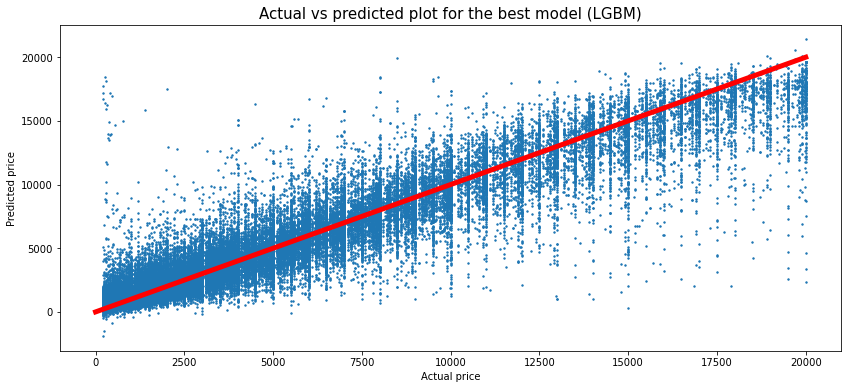

In [149]:
plt.figure(figsize=(14,6))
plt.scatter(y_test, y_pred_boost, s=2)
plt.plot([0, 20000], [0, 20000], c='r', linewidth=5)
plt.title('Actual vs predicted plot for the best model (LGBM)', fontsize=15)
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.show()

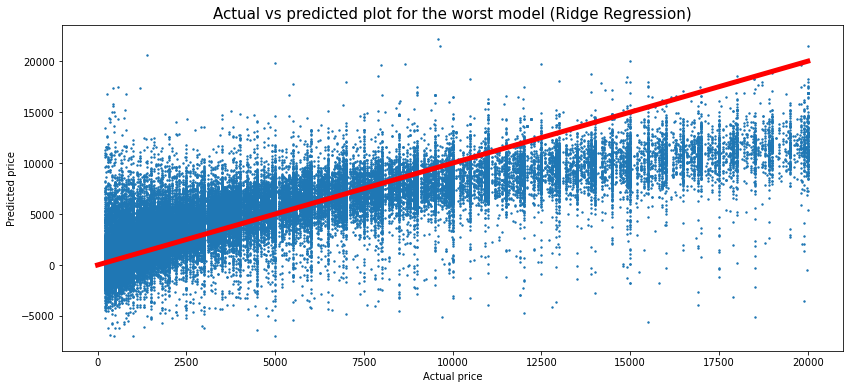

In [150]:
plt.figure(figsize=(14,6))
plt.scatter(y_test, y_pred_ridge, s=2)
plt.plot([0, 20000], [0, 20000], c='r', linewidth=5)
plt.title('Actual vs predicted plot for the worst model (Ridge Regression)', fontsize=15)
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.show()

Результат налицо.

### Проверка модели на адекватность

Проверим модели на адекватность через сравнение с константной моделью.

In [151]:
dummy_mean = DummyRegressor(strategy='mean')
dummy_mean.fit(X_train, y_train)
mean_squared_error(y_test, dummy_mean.predict(X_test)) ** 0.5

4510.763201624899

In [152]:
dummy_median = DummyRegressor(strategy='median')
dummy_median.fit(X_train, y_train)
mean_squared_error(y_test, dummy_median.predict(X_test)) ** 0.5

4816.72557817451

Все обученные модели показали куда лучшее качество, чем константные модели на основе среднего и медианы.

### Важность признаков

На основе модели градиентного бустинга посмотрим, какие признаки вносят наибольший вклад в предсказание.

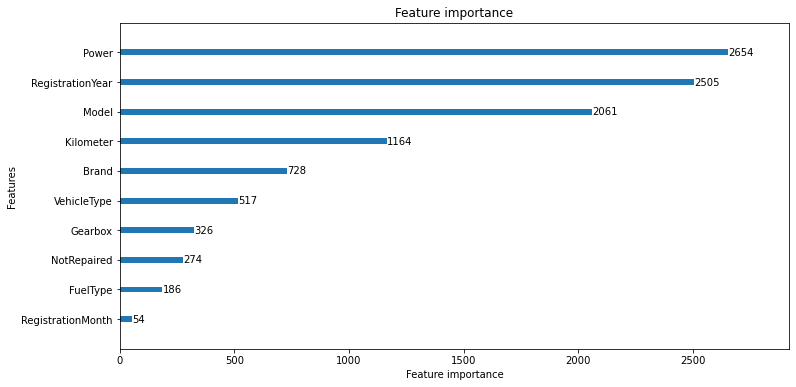

In [153]:
lightgbm.plot_importance(boost, figsize=(12,6), grid=False)
plt.show()

- Наибольший вклад вносят мощность двигателя и год регистрации.
- Наименьший вклад - месяц регистрации и тип топлива, что ожидаемо. На стадии анализа данных отмечалось, что месяц регистрации скорее всего никак не влияет, выделялся лишь нулевой месяц. В итоге было решено изменить признак, оставив лишь 0 и 1, показывая, является ли месяц нулевым или нет. Касательно топлива, подавляющее большинство автомобилей в наборе данных используют бензин, который почему-то был записан по-разному: *petrol* и *gasoline*, и цены были разные, поэтому было решено оставить данный столбец.

### Анализ остатков

Посчитаем остатки наилучшей модели. 

In [177]:
residuals = y_test - y_pred_boost

Положительный остаток значит, что модель дала цену ниже реально, отрицательный остаток - предсказанная цена завышена.

Для удобства добавим в таблицу.

In [178]:
X_test_boost['residual'] = residuals

In [179]:
X_test_boost.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,residual
289278,wagon,2009.0,manual,110.0,passat,150000,1,gasoline,volkswagen,no,959.781376
283376,NaN,1995.0,NaN,NaN,fiesta,80000,0,NaN,ford,NaN,284.147642
166815,sedan,2008.0,manual,80.0,polo,60000,1,petrol,volkswagen,no,833.905706
158549,other,1999.0,manual,68.0,other,150000,1,gasoline,seat,yes,135.387987
132134,sedan,2010.0,auto,245.0,7er,60000,1,gasoline,bmw,no,24.022293


Взглянем на распределение остатков.

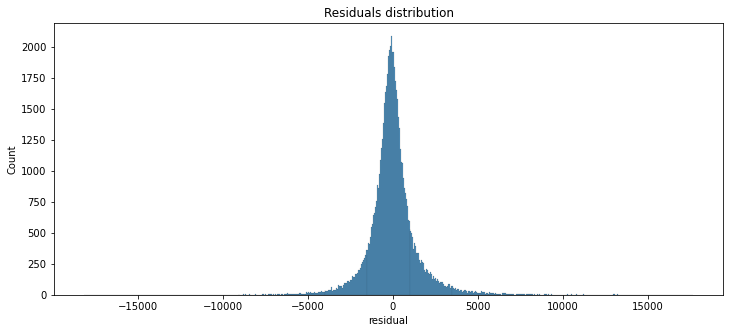

In [183]:
plt.figure(figsize=(12,5))
sns.histplot(X_test_boost['residual'])
plt.title('Residuals distribution')
plt.show()

Остатки распределены нормально вокруг нуля, все в порядке.

Посмотрим на влияние на остатки численных признаков. Начнем с года регистрации.

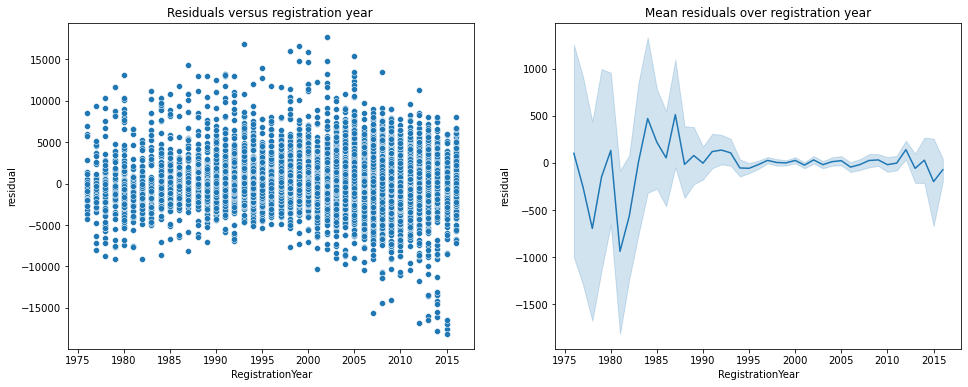

In [213]:
_, axes = plt.subplots(1, 2, figsize=(16,6))
sns.scatterplot(data=X_test_boost, x='RegistrationYear', y='residual', ax=axes[0])
axes[0].set_title('Residuals versus registration year ')
sns.lineplot(data=X_test_boost, x='RegistrationYear', y='residual', ax=axes[1])
axes[1].set_title('Mean residuals over registration year')
plt.show()

Модели тяжело предсказывать цену старых автомобилей. Модель стабильно работает для авто 1995-2010 года регистрации. Новым автомобилям модель завышает цену.

Теперь рассмотрим мощность двигателя.

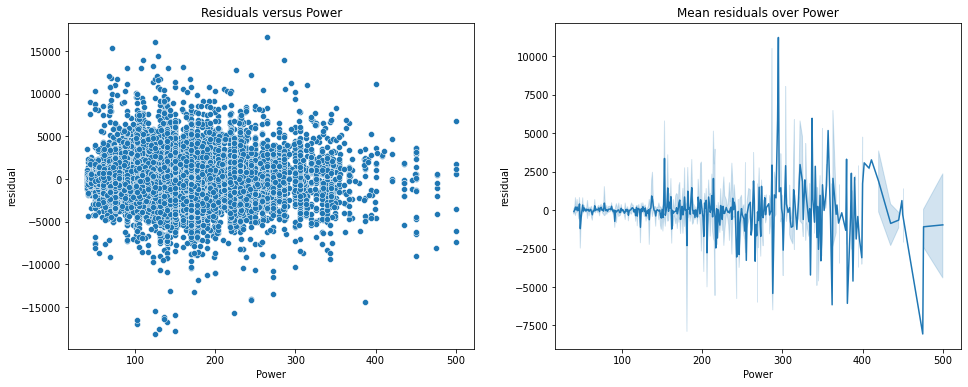

In [214]:
_, axes = plt.subplots(1, 2, figsize=(16,6))
sns.scatterplot(data=X_test_boost, x='Power', y='residual', ax=axes[0])
axes[0].set_title('Residuals versus Power')
sns.lineplot(data=X_test_boost, x='Power', y='residual', ax=axes[1])
axes[1].set_title('Mean residuals over Power')
plt.show()

Модель стабильно работает для автомобилей с низкими мощностями (примерно до 200-250 л.с.). Затем ошибка начинается увеличиваться.

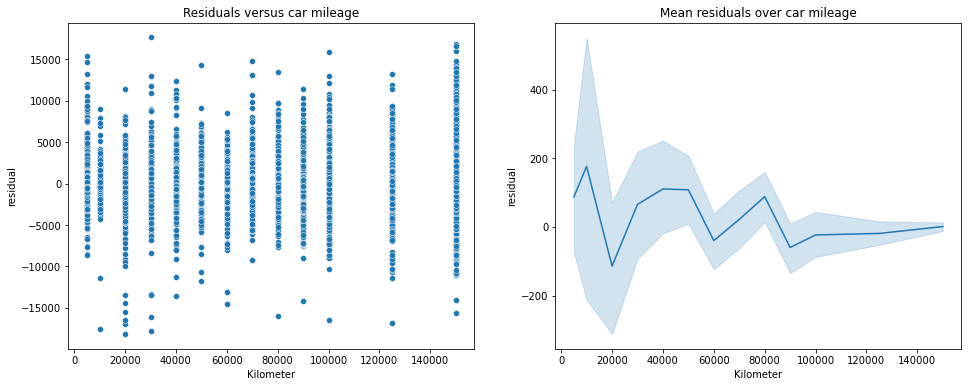

In [217]:
_, axes = plt.subplots(1, 2, figsize=(16,6))
sns.scatterplot(data=X_test_boost, x='Kilometer', y='residual', ax=axes[0])
axes[0].set_title('Residuals versus car mileage')
sns.lineplot(data=X_test_boost, x='Kilometer', y='residual', ax=axes[1])
axes[1].set_title('Mean residuals over car mileage')
plt.show()

Чем выше пробег автомобиля, тем лучше модель предсказывает его цену.

Теперь рассмотрим несколько категориальных признаков.

Начнем с типа кузова. Посмотрим, какие средние остатков имеют разные типы кузова.

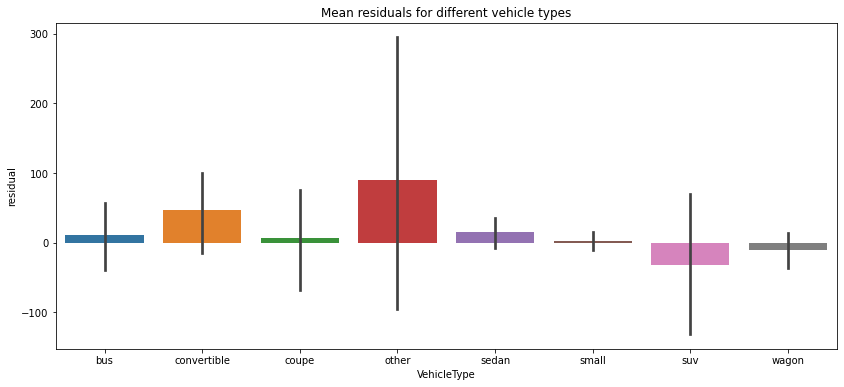

In [234]:
plt.figure(figsize=(14,6))
sns.barplot(data=X_test_boost, y='residual', x='VehicleType')
plt.title('Mean residuals for different vehicle types')
plt.show()

Модель очень хорошо предсказывает цену для маленьких кузовов (вертикальные линии на графике показывают 95-й доверительный интервал). Хуже всего модель работает с типом кузова "другой". Модель занижает цену для всех типов кузова, кроме спортивного и универсала.

Теперь посмотрим на коробку передач.

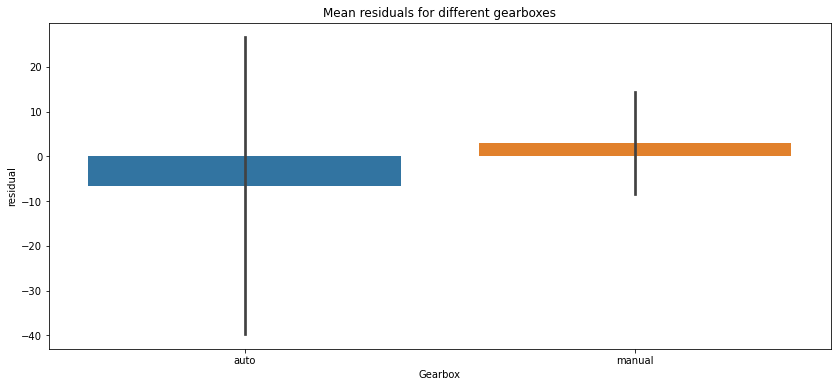

In [236]:
plt.figure(figsize=(14,6))
sns.barplot(data=X_test_boost, y='residual', x='Gearbox')
plt.title('Mean residuals for different gearboxes')
plt.show()

В среднем модель завышает цену для автоматической коробки передач, но занижает цены для механической коробки. Модель лучше предсказывает цену для механической коробки.

Оценить остатки для моделей сложнее из-за большого количества последних. Посмотрим на 10 моделей авто, для которых наша модель в среднем завышает цену.

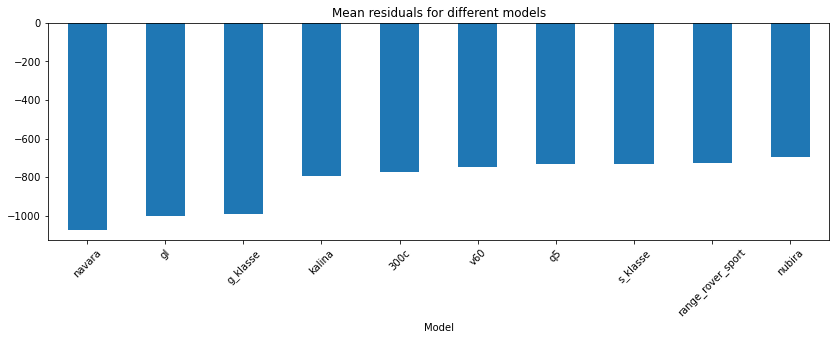

In [257]:
X_test_boost.groupby('Model')['residual'].mean().sort_values()[:10].plot(kind='bar', figsize=(14,4))
plt.title('Mean residuals for different models')
plt.xticks(rotation=45)
plt.show()

В списке самых переоценных моделей несколько представителей мерседеса. Удивительно, но и Лада Калина здесь.

Теперь взглянем на 10 недооцененных моделей.

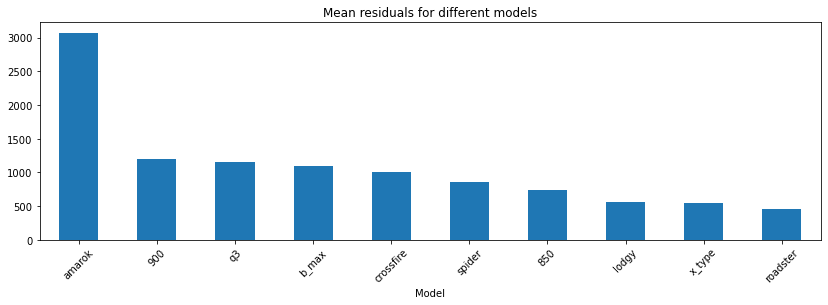

In [256]:
X_test_boost.groupby('Model')['residual'].mean().sort_values(ascending=False)[:10].plot(kind='bar', figsize=(14,4))
plt.title('Mean residuals for different models')
plt.xticks(rotation=45)
plt.show()

Сильно выбивается некий "amarok". Взглянем на него в таблице.

In [255]:
df.query('Model == "amarok"')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
42875,13800,NaN,NaN,NaN,NaN,amarok,150000,1,gasoline,volkswagen,no
77352,19900,suv,2011.0,manual,163.0,amarok,90000,1,gasoline,volkswagen,no
81620,19000,suv,2010.0,manual,163.0,amarok,80000,1,gasoline,volkswagen,no
91704,18800,suv,2011.0,manual,163.0,amarok,80000,1,gasoline,volkswagen,no
101953,384,suv,2015.0,manual,140.0,amarok,30000,1,gasoline,volkswagen,no
110872,20000,suv,2010.0,manual,163.0,amarok,80000,1,gasoline,volkswagen,no
114348,10000,suv,2011.0,manual,163.0,amarok,150000,1,gasoline,volkswagen,no
120034,19500,suv,2010.0,manual,163.0,amarok,70000,1,gasoline,volkswagen,no
181594,19000,suv,2010.0,manual,163.0,amarok,80000,1,gasoline,volkswagen,no
229520,5500,suv,2012.0,manual,163.0,amarok,50000,1,gasoline,volkswagen,yes


Довольно дорогая спортивная машина. В одной строке видна аномалия. Цена такой машины не может быть 384 евро. Возможно это повлияло на обучение модели.

Теперь взглянем на марки по той же схеме. Сначала 10 переоцененных моделью.

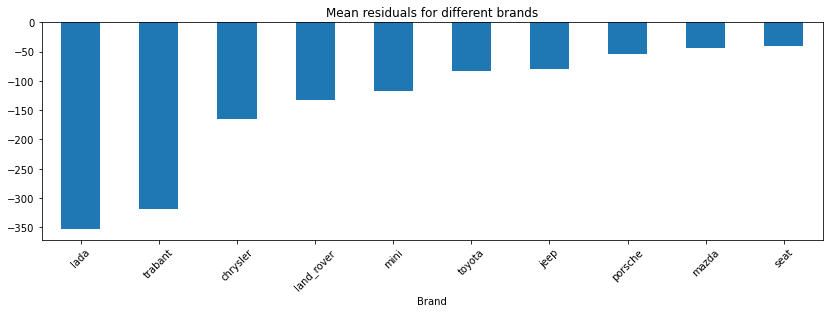

In [259]:
X_test_boost.groupby('Brand')['residual'].mean().sort_values()[:10].plot(kind='bar', figsize=(14,4))
plt.title('Mean residuals for different brands')
plt.xticks(rotation=45)
plt.show()

Модели переоценивает Ладу и некий Трабант.

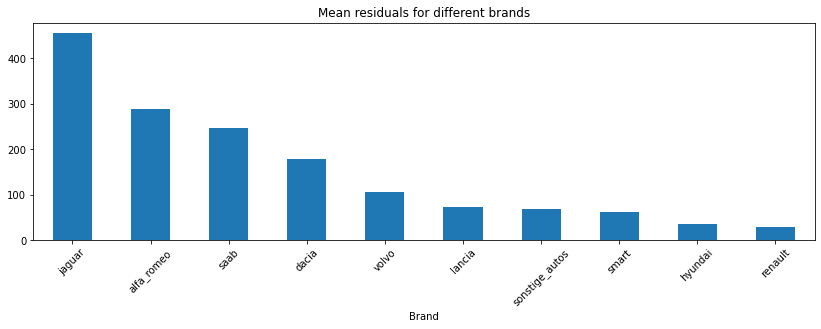

In [260]:
X_test_boost.groupby('Brand')['residual'].mean().sort_values(ascending=False)[:10].plot(kind='bar', figsize=(14,4))
plt.title('Mean residuals for different brands')
plt.xticks(rotation=45)
plt.show()

Самые недооцененные - Ягуар и Альфа-ромео.

Посмотрим на тип топлива.

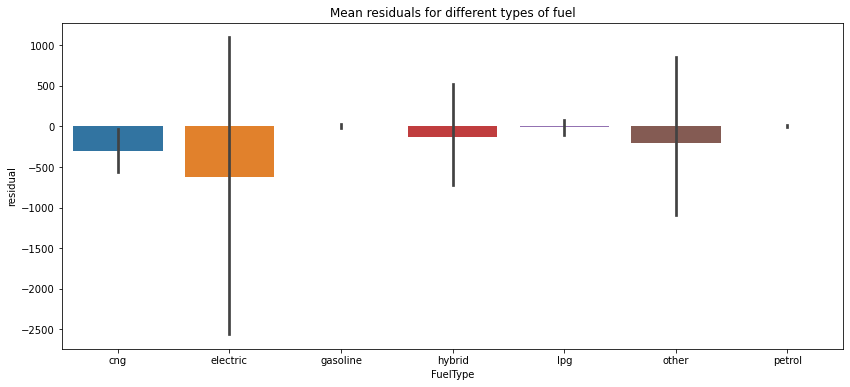

In [261]:
plt.figure(figsize=(14,6))
sns.barplot(data=X_test_boost, y='residual', x='FuelType')
plt.title('Mean residuals for different types of fuel')
plt.show()

Модель хорошо работает с бензиновыми автомобилями, с остальными типами топлива ситуация хуже.

Теперь посмотрим на факт ремонта.

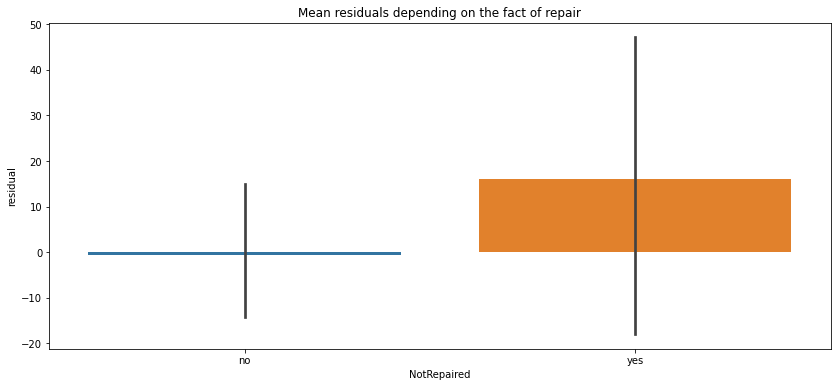

In [264]:
plt.figure(figsize=(14,6))
sns.barplot(data=X_test_boost, y='residual', x='NotRepaired')
plt.title('Mean residuals depending on the fact of repair')
plt.show()

Модель лучше предсказывает цену для авто без ремонта. Интересно, но модель в среднем занижает цену для машин, побывавших в ремонте.